# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [10]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [11]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [12]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

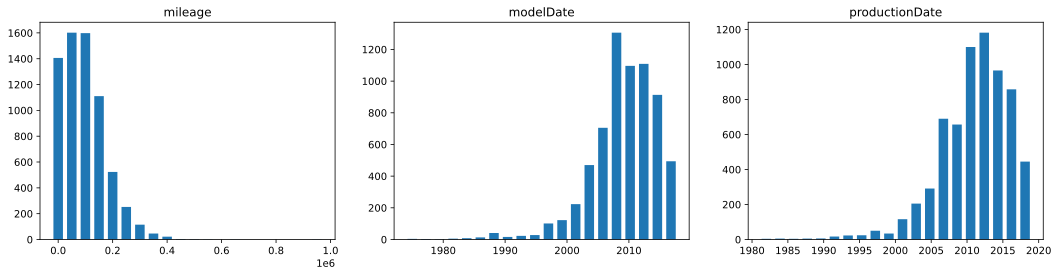

In [13]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [14]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [15]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [16]:
round(data.isna().sum() / data.shape[0] * 100, 2)

bodyType                 0.00
brand                    0.00
color                    0.00
description              0.00
engineDisplacement       0.00
enginePower              0.00
fuelType                 0.00
mileage                  0.00
modelDate                0.00
model_info               0.00
name                     0.00
numberOfDoors            0.00
productionDate           0.00
sell_id                  0.00
vehicleConfiguration     0.00
vehicleTransmission      0.00
Владельцы                0.01
Владение                64.86
ПТС                      0.00
Привод                   0.00
Руль                     0.00
sample                   0.00
price                    0.00
dtype: float64

In [17]:
for column in categorical_features:
    print(column, data[column].nunique())

bodyType 17
brand 3
color 16
engineDisplacement 48
enginePower 154
fuelType 4
model_info 122
name 976
numberOfDoors 4
vehicleTransmission 4
Владельцы 3
Владение 180
ПТС 2
Привод 3
Руль 2


In [18]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 

    
    df_output['xDrive'] = df_output['name'].str.contains('xDrive').astype(int)
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: None if x == 'undefined LTR' else x.split()[0]).astype(float)
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: x.split()[0]).astype(int)
    
    df_output['modelDateNorm'] = np.log(2020 - df_output['modelDate'])
    df_output['enginePowerNorm'] = np.log(df_output['enginePower'])
    
    
    for x in ['name', 'engineDisplacement', 'enginePower']:
        categorical_features.remove(x)
        
    for x in ['modelDate']:
        numerical_features.remove(x)
        
    numerical_features.extend(['modelDateNorm', 'engineDisplacement', 'enginePowerNorm', 'xDrive'])
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ##############################################################
    df_output['bodyType'] = df_output['bodyType'].apply(lambda x: x.split()[0])
    
    
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)


    
    # ################### Clean ####################################################
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    df_output.drop(['description','sell_id', 'name'], axis = 1, inplace=True)
    
    
    return df_output

In [19]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,xDrive,modelDateNorm,enginePowerNorm,...,Владение_177,Владение_178,Владение_179,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7399,0.220339,245,0.106999,2014,0.868421,1,1590000.0,1.0,0.460391,0.529985,...,0,0,0,0,1,0,0,1,1,0
4273,0.220339,245,0.044999,2013,0.894737,1,3100000.0,0.0,0.500000,0.529985,...,0,0,0,0,1,0,0,1,1,0
3362,0.813559,585,0.054999,2013,0.868421,1,3750000.0,0.0,0.500000,0.919650,...,0,0,0,0,1,0,0,1,1,0
2794,0.389831,245,0.124999,2011,0.763158,1,1990000.0,0.0,0.564575,0.529985,...,0,0,0,0,1,0,0,1,1,0
5378,0.220339,218,0.148999,2013,0.868421,1,1285000.0,1.0,0.500000,0.477709,...,0,0,0,0,1,0,0,1,1,0
5902,0.559322,560,0.069799,2012,0.815789,1,3399999.0,0.0,0.534311,0.900097,...,0,0,0,0,1,0,0,1,1,0
1454,0.389831,320,0.052765,2012,0.868421,0,0.0,1.0,0.534311,0.649551,...,0,0,0,0,1,0,0,1,1,0
2476,0.305085,218,0.173499,2007,0.684211,1,700000.0,0.0,0.659062,0.477709,...,0,0,0,1,0,1,0,0,1,0
743,0.152542,115,0.119999,2007,0.736842,0,0.0,0.0,0.659062,0.191371,...,0,0,0,0,1,1,0,0,1,0
1168,0.813559,544,0.035999,2012,0.842105,0,0.0,0.0,0.534311,0.887119,...,0,0,0,0,1,0,0,1,1,0


In [20]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 368 entries, engineDisplacement to Руль_1
dtypes: float64(7), int64(3), uint8(358)
memory usage: 3.5 MB


## Split data

In [21]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [22]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 367 entries, engineDisplacement to Руль_1
dtypes: float64(7), int64(2), uint8(358)
memory usage: 714.7 KB


# Model 2: CatBoostRegressor

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [24]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.1,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.9859435	test: 1.0100072	best: 1.0100072 (0)	total: 54.1ms	remaining: 4m 30s
100:	learn: 0.2932587	test: 0.2920118	best: 0.2920118 (100)	total: 405ms	remaining: 19.6s
200:	learn: 0.2317272	test: 0.2293922	best: 0.2293922 (200)	total: 736ms	remaining: 17.6s
300:	learn: 0.1979808	test: 0.1965730	best: 0.1965730 (300)	total: 1.06s	remaining: 16.5s
400:	learn: 0.1846516	test: 0.1844713	best: 0.1844708 (399)	total: 1.37s	remaining: 15.7s
500:	learn: 0.1754299	test: 0.1761812	best: 0.1761812 (500)	total: 1.69s	remaining: 15.2s
600:	learn: 0.1680102	test: 0.1694825	best: 0.1694825 (600)	total: 2.01s	remaining: 14.7s
700:	learn: 0.1600169	test: 0.1618812	best: 0.1618812 (700)	total: 2.34s	remaining: 14.4s
800:	learn: 0.1552555	test: 0.1576550	best: 0.1576456 (798)	total: 2.68s	remaining: 14.1s
900:	learn: 0.1502002	test: 0.1534411	best: 0.1534271 (899)	total: 3.01s	remaining: 13.7s
1000:	learn: 0.1468899	test: 0.1505707	best: 0.1505707 (1000)	total: 3.3

In [25]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.24%


### Submission

In [26]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

Изменения признаков дало улучшение до 12.24%

Изменение LR улучшений не дало

# Model 3: Tabular NN

Построим обычную сеть:

In [27]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,xDrive,modelDateNorm,enginePowerNorm,bodyType_0,bodyType_1,...,Владение_177,Владение_178,Владение_179,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7320,0.898305,544,0.149999,2008,0.763158,0.0,0.638495,0.887119,0,0,...,0,0,0,0,1,1,0,0,1,0
8037,0.220339,245,0.020941,2016,0.947368,0.0,0.356207,0.529985,1,0,...,0,0,0,0,1,0,0,1,1,0
4681,0.406780,255,0.133896,2004,0.631579,0.0,0.712414,0.547896,0,0,...,0,0,0,0,1,0,0,1,1,0
6014,0.186441,184,0.329999,2006,0.657895,0.0,0.678104,0.401796,0,0,...,0,0,0,0,1,1,0,0,1,0
3649,0.389831,313,0.125999,2011,0.815789,1.0,0.564575,0.639649,0,0,...,0,0,0,0,1,0,0,1,1,0


## Simple Dense NN

In [28]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.2))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.3))
model.add(L.Dense(1, activation="linear"))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               187904    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 319,489
Trainable params: 319,489
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [31]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [32]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

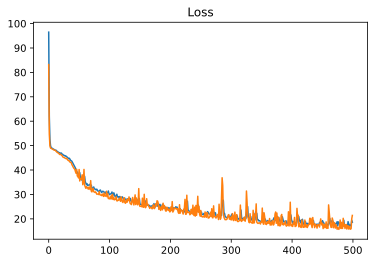

In [33]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [34]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [35]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 21.41%


С измененными признаками и стандартной моделью результат 18.03%

При изменении в модели слоев dropout с параметрами 0.2 и 0.3 результат 15.53%

In [36]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [37]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [38]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [39]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [40]:
import nltk
from nltk.corpus import stopwords

stopwords_ru = list(set(stopwords.words('russian')))

In [41]:
import re
# patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]"
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]"
pattern_2 = '\n'

desc_nlp = data.description.copy()
desc_nlp = desc_nlp.apply(lambda x: re.sub(patterns, ' ', x))
desc_nlp = desc_nlp.apply(lambda x: re.sub(pattern_2, ' ', x))
desc_nlp.iloc[0]

'Всем привет   Продам эксклюзивный проект     универсал    TE    SportLine  Модель             TE    Двигатель         Трансмиссия         Цвет кузова      черный  Отделка салона      Кожа черная    антрацит    Опции      Автоматическая блокировка дифференциала  ASD      Индикатор внешней температуры     Спортивные сиденья спереди     Спортивное рулевое колесо с отделкой из кожи  диаметр     мм  и кожаный рычаг КПП     Подушка безопасности для водителя и переднего пассажира     Дополнительный бардачок в вещевом отсеке спереди     Люк с электроприводом и устройством подъёма     Автоматическая коробка передач  напольное исполнение     Темпомат  круиз контроль      Автоматическая антенна     Двойные занавески для багажного пространства и пасажирского отсека  сетка шторка      Складной подлокотник спереди     Кондиционер Behr и электрические стеклоподъемники передних и задних дверей     Атермальные боковые и заднее стекла  заднее стекло с подогревом  ESG      Спортивная подвеска     АКБ ув

Лемматизация

In [42]:
!pip install pymorphy2
import pymorphy2

     |████████████████████████████████| 55 kB 312 kB/s 
     |████████████████████████████████| 8.2 MB 5.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [43]:
morph = pymorphy2.MorphAnalyzer()
desc_nlp = desc_nlp.apply(lambda x: " ".join(morph.normal_forms(y)[0] for y in x.split()))
desc_nlp = desc_nlp.apply(lambda x: " ".join(y for y in x.split() if y not in stopwords_ru))
desc_nlp[0]

'весь привет продать эксклюзивный проект универсал te sportline модель te двигатель трансмиссия цвет кузов чёрный отделка салон кожа чёрный антрацит опция автоматический блокировка дифференциал asd индикатор внешний температура спортивный сидение спереди спортивный рулевой колесо отделка кожа диаметр мм кожаный рычаг кпп подушка безопасность водитель передний пассажир дополнительный бардачок вещевой отсек спереди люк электропривод устройство подъём автоматический коробка передача напольный исполнение темпомат круиз контроль автоматический антенна двойной занавеска багажный пространство пасажирский отсек сетка шторка складный подлокотник спереди кондиционер behr электрический стеклоподъёмник передний задний дверь атермальный боковой задний стекло задний стекло подогрев esg спортивный подвеска акб увеличить мощность установленный сзади динамика электрообогрев передний кресло исполнение sportline код дополнительно установленный опция внутренний салонный зеркало автоматический изменение за

### Tokenizer

In [44]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(desc_nlp)

CPU times: user 1.08 s, sys: 5.89 ms, total: 1.09 s
Wall time: 1.09 s


In [45]:
# tokenize.word_index

In [46]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.17 s, sys: 8.84 ms, total: 1.18 s
Wall time: 1.18 s


In [47]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [48]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [49]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.2))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.3))

### Multiple Inputs NN

In [50]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [51]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     4764416     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [52]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

Оптимизаторы SGD, RMSprop не дали улучшения модели

Изменение коэффициента LR дает лишь небольшое улучшение, что сопоставимо с погрешностью

In [53]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [54]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 299ms/step - loss: 84.7246 - MAPE: 84.7246 - val_loss: 55.0467 - val_MAPE: 55.0467
Epoch 2/500
12/12 [==============================] - 3s 238ms/step - loss: 53.3074 - MAPE: 53.3074 - val_loss: 50.8254 - val_MAPE: 50.8254
Epoch 3/500
12/12 [==============================] - 3s 243ms/step - loss: 49.4178 - MAPE: 49.4178 - val_loss: 49.0086 - val_MAPE: 49.0086
Epoch 4/500
12/12 [==============================] - 3s 230ms/step - loss: 49.0707 - MAPE: 49.0707 - val_loss: 49.3570 - val_MAPE: 49.3570
Epoch 5/500
12/12 [==============================] - 3s 242ms/step - loss: 49.0349 - MAPE: 49.0349 - val_loss: 48.5798 - val_MAPE: 48.5798
Epoch 6/500
12/12 [==============================] - 3s 235ms/step - loss: 48.3702 - MAPE: 48.3702 - val_loss: 48.2518 - val_MAPE: 48.2518
Epoch 7/500
12/12 [==============================] - 3s 235ms/step - loss: 48.1532 - MAPE: 48.1532 - val_loss: 47.9361 - val_MAPE: 47.9361
Epoch 8/500
12/12 [========

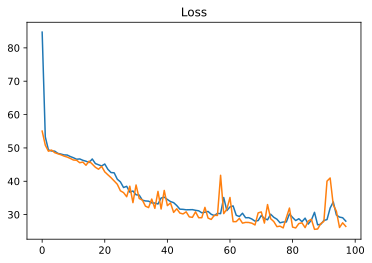

In [55]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [56]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [57]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 26.46%


С изменненными признаками и стандартной моделью результат 30.10%

C изменненными признаками, MAX_WORDS = 10000 и измененной моделью результат 22.31%

C измененными признаками, очисткой текста и лемматизацией, MAX_WORDS = 10000 и измененной модель результат 25.52%

In [58]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: Добавляем картинки

### Data

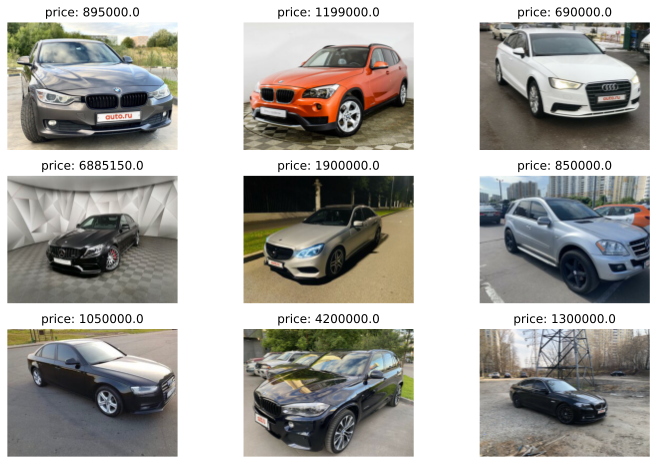

In [59]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [60]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

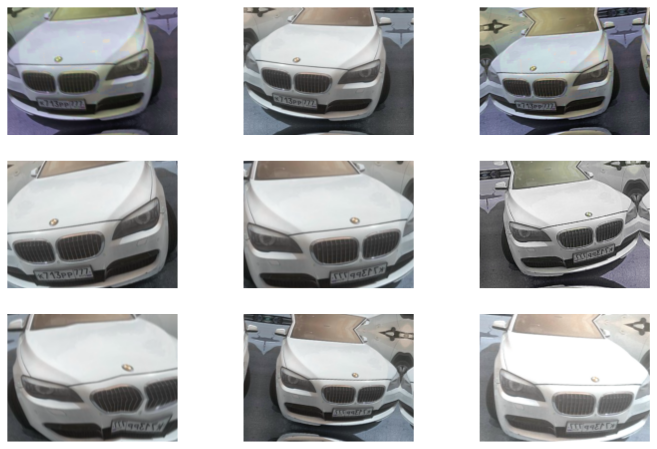

In [61]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [62]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [63]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
# tokenize.fit_on_texts(data.description)
tokenize.fit_on_texts(desc_nlp)

In [64]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [65]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 3s 0us/step


In [66]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.2),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.3),
    ])

In [67]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [68]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [69]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [70]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [71]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 130s 685ms/step - loss: 53.0883 - MAPE: 53.0883 - val_loss: 12113.8711 - val_MAPE: 12113.8711
Epoch 2/100
190/190 [==============================] - 127s 667ms/step - loss: 47.7290 - MAPE: 47.7290 - val_loss: 52.8317 - val_MAPE: 52.8317
Epoch 3/100
190/190 [==============================] - 125s 659ms/step - loss: 46.6602 - MAPE: 46.6602 - val_loss: 44.8360 - val_MAPE: 44.8360
Epoch 4/100
190/190 [==============================] - 125s 659ms/step - loss: 45.8362 - MAPE: 45.8362 - val_loss: 43.0718 - val_MAPE: 43.0718
Epoch 5/100
190/190 [==============================] - 126s 662ms/step - loss: 44.3674 - MAPE: 44.3674 - val_loss: 42.0115 - val_MAPE: 42.0115
Epoch 6/100
190/190 [==============================] - 126s 661ms/step - loss: 41.5674 - MAPE: 41.5674 - val_loss: 38.1129 - val_MAPE: 38.1129
Epoch 7/100
190/190 [==============================] - 126s 663ms/step - loss: 39.0611 - MAPE: 39.0611 - val_loss: 35.6607 - val_MAPE: 3

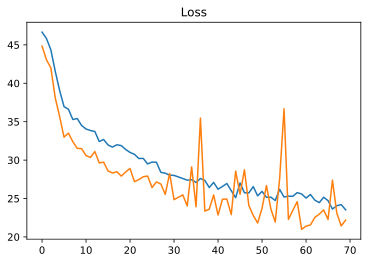

In [72]:
plt.title('Loss')
plt.plot(history.history['MAPE'][2:], label='train')
plt.plot(history.history['val_MAPE'][2:], label='test')
plt.show();

In [73]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [74]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 22.19%


С измененными признаками и стандартной моделью результат 33.54%

C измененными признаками, очисткой текста и лемматизацией и измененной моделью (без уменьшения количетсва слов) результат 24.21%

C измененными признаками, очисткой текста и лемматизацией и измененной моделью результат 19.97%

Изменение LR с 0.005 до 0.001 со всеми измененеиями привело к 21.65%

In [75]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning


#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [76]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 14.38%


С измененными признаками и стандартной моделью результат 19.41%

С измененными признаками, очисткой текста и лемматизацией результат 20.03%

С измененными признаками, очисткой текста, лемматизацией и измененной моделью (без изменения количества слов) результат 15.34%

С измененными признаками, очисткой текста, лемматизацией и измененной моделью результат 13.95%

С измененным LR результат 14.25%

In [77]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [78]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [79]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [80]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [81]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 366)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          187904      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [82]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [83]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 20ms/step - loss: 91.4964 - MAPE: 91.4964 - val_loss: 52.2506 - val_MAPE: 52.2506
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 53.5411 - MAPE: 53.5411 - val_loss: 52.6304 - val_MAPE: 52.6304
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 51.9148 - MAPE: 51.9148 - val_loss: 51.0648 - val_MAPE: 51.0648
Epoch 4/500
12/12 [==============================] - 0s 8ms/step - loss: 50.4524 - MAPE: 50.4524 - val_loss: 49.0917 - val_MAPE: 49.0917
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 49.6269 - MAPE: 49.6269 - val_loss: 48.8036 - val_MAPE: 48.8036
Epoch 6/500
12/12 [==============================] - 0s 8ms/step - loss: 49.1698 - MAPE: 49.1698 - val_loss: 48.4059 - val_MAPE: 48.4059
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 48.9580 - MAPE: 48.9580 - val_loss: 48.1379 - val_MAPE: 48.1379
Epoch 8/500
12/12 [=====================

In [84]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 29.22%


In [85]:
bonus_predict = model.predict([X_sub, X_sub.productionDate.values])
sample_submission['price'] = bonus_predict[:,0]
sample_submission.to_csv('bonus_submission.csv', index=False)

In [86]:
# 